In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif, RFE

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score, roc_curve, confusion_matrix, roc_auc_score, classification_report

In [45]:
df = pd.read_csv('mountains_vs_beaches_preferences.csv')
df.head()

,Age,Gender,Income,Education_Level,Travel_Frequency,Preferred_Activities,Vacation_Budget,Location,Proximity_to_Mountains,Proximity_to_Beaches,Favorite_Season,Pets,Environmental_Concerns,Preference
0,56,male,71477,bachelor,9,skiing,2477,urban,175,267,summer,0,1,1
1,69,male,88740,master,1,swimming,4777,suburban,228,190,fall,0,1,0
2,46,female,46562,master,0,skiing,1469,urban,71,280,winter,0,0,1
3,32,non-binary,99044,high school,6,hiking,1482,rural,31,255,summer,1,0,1
4,60,female,106583,high school,5,sunbathing,516,suburban,23,151,winter,1,1,0


**Inspecting dataset**

In [9]:
print(df.shape)

(52444, 14)


In [16]:
print(df.dtypes)

Age                        int64
Gender                    object
Income                     int64
Education_Level           object
Travel_Frequency           int64
Preferred_Activities      object
Vacation_Budget            int64
Location                  object
Proximity_to_Mountains     int64
Proximity_to_Beaches       int64
Favorite_Season           object
Pets                       int64
Environmental_Concerns     int64
Preference                 int64
dtype: object


In [6]:
df[df.duplicated]

,Age,Gender,Income,Education_Level,Travel_Frequency,Preferred_Activities,Vacation_Budget,Location,Proximity_to_Mountains,Proximity_to_Beaches,Favorite_Season,Pets,Environmental_Concerns,Preference


In [7]:
df.isnull().mean().sort_values()

Age                       0.0
Gender                    0.0
Income                    0.0
Education_Level           0.0
Travel_Frequency          0.0
Preferred_Activities      0.0
Vacation_Budget           0.0
Location                  0.0
Proximity_to_Mountains    0.0
Proximity_to_Beaches      0.0
Favorite_Season           0.0
Pets                      0.0
Environmental_Concerns    0.0
Preference                0.0
dtype: float64

In [22]:
df['Preference'].value_counts()

Preference
0    39296
1    13148
Name: count, dtype: int64

In [79]:
# the target class is unbalance, accuracy score is not suitable to evaluate the data model

In [25]:
categorical_features = []
for column in df.columns:
    if df[column].dtype == object:
        print(df[column].value_counts(), '\n')
        categorical_features.append(column)

print(categorical_features)

Gender
female        17638
male          17522
non-binary    17284
Name: count, dtype: int64 

Education_Level
doctorate      13293
bachelor       13127
high school    13072
master         12952
Name: count, dtype: int64 

Preferred_Activities
sunbathing    13221
skiing        13167
hiking        13102
swimming      12954
Name: count, dtype: int64 

Location
suburban    17503
urban       17476
rural       17465
Name: count, dtype: int64 

Favorite_Season
summer    13303
fall      13170
winter    13019
spring    12952
Name: count, dtype: int64 

['Gender', 'Education_Level', 'Preferred_Activities', 'Location', 'Favorite_Season']


**Feature Engineering**

One-hot encoding categorical features

In [46]:
for feature in categorical_features:
    binned = pd.get_dummies(df[feature])
    binned = binned.drop(binned.columns[-1], axis=1) # drop the last dummy variable
    df = df.join(binned)
    df = df.drop(feature, axis=1)

df.head()

,Age,Income,Travel_Frequency,Vacation_Budget,Proximity_to_Mountains,Proximity_to_Beaches,Pets,Environmental_Concerns,Preference,female,...,doctorate,high school,hiking,skiing,sunbathing,rural,suburban,fall,spring,summer
0,56,71477,9,2477,175,267,0,1,1,False,...,False,False,False,True,False,False,False,False,False,True
1,69,88740,1,4777,228,190,0,1,0,False,...,False,False,False,False,False,False,True,True,False,False
2,46,46562,0,1469,71,280,0,0,1,True,...,False,False,False,True,False,False,False,False,False,False
3,32,99044,6,1482,31,255,1,0,1,False,...,False,True,True,False,False,True,False,False,False,True
4,60,106583,5,516,23,151,1,1,0,True,...,False,True,False,False,True,False,True,False,False,False


Detecting correlated features

In [4]:
def correlatedFeatures(dataset, threshold):
    """
    Function to detect correlated features

    Input: df, correlation threshold
    Return: Set of correlated features
    """
    correlated_columns = set()
    correlations = dataset.corr()
    for i in range(len(correlations)):
        for j in range(i):
            if abs(correlations.iloc[i,j]) > threshold:
                correlated_columns.add(correlations.columns[i])
    return correlated_columns

In [38]:
correlatedFeatures(df, 0.8)

set()

In [78]:
# no highly correlated feature (correlation index > 0.8)

Detect low variance feature

In [47]:
X = df.drop('Preference', axis=1)
y = df['Preference']

test_size = 0.33
seed = 1

scaler = MinMaxScaler(feature_range=(0,1))
X_ = scaler.fit_transform(X)
X = pd.DataFrame(X_, columns=X.columns)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

In [48]:
sel = VarianceThreshold(threshold=(0.02))
sel.fit(X)

print("Feature selection", sel.get_support())
print("Selected features:", list(X.columns[sel.get_support()]))
print("Removed features:", list(X.columns[~sel.get_support()]))

Feature selection [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True]
Selected features: ['Age', 'Income', 'Travel_Frequency', 'Vacation_Budget', 'Proximity_to_Mountains', 'Proximity_to_Beaches', 'Pets', 'Environmental_Concerns', 'female', 'male', 'bachelor', 'doctorate', 'high school', 'hiking', 'skiing', 'sunbathing', 'rural', 'suburban', 'fall', 'spring', 'summer']
Removed features: []


In [59]:
# No low variance feature

Select N strongly related features

In [ ]:
kbest = SelectKBest(score_func=f_classif, k=6)
kbest.fit(X, y)

print("Feature selection", kbest.get_support())
print("Feature scores", kbest.scores_)
print("Selected features:", list(X.columns[kbest.get_support()]))
print("Removed features:", list(X.columns[~kbest.get_support()]))

Feature selection [False False False False  True  True  True False False False False False
 False  True  True  True False False False False False]
Feature scores [5.14017859e-02 4.71273080e-01 1.48076433e-01 1.18503220e+00
 6.64591006e+03 6.62248368e+03 6.78676964e+00 1.11312611e-01
 1.11145652e-02 1.20438195e-02 1.24567705e+00 5.87279430e+00
 2.87310532e+00 6.54706890e+03 6.54840714e+03 6.66627340e+03
 9.43073457e-01 1.49522702e-01 3.16304809e-01 1.55183457e-01
 6.61878164e-01]
Selected features: ['Proximity_to_Mountains', 'Proximity_to_Beaches', 'Pets', 'hiking', 'skiing', 'sunbathing']
Removed features: ['Age', 'Income', 'Travel_Frequency', 'Vacation_Budget', 'Environmental_Concerns', 'female', 'male', 'bachelor', 'doctorate', 'high school', 'rural', 'suburban', 'fall', 'spring', 'summer']


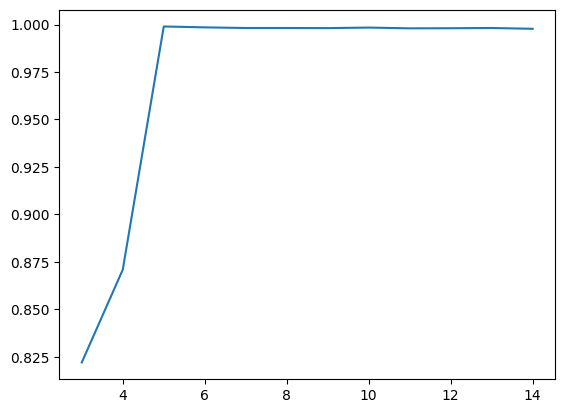

In [58]:
test_result_df = pd.DataFrame(columns=['N', 'Score'])
n_list = []
score_list = []
for n_best in range(3, 15):
    kbest = SelectKBest(score_func=f_classif, k=n_best)
    kbest.fit(X, y)
    X_ = kbest.transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_, y, test_size=test_size, random_state=seed)
    model = LogisticRegression()
    model.fit(X_train, y_train)
    yhat = model.predict(X_test)
    score = accuracy_score(y_pred=yhat, y_true=y_test)
    # print(str(n_best), ': ', score)
    n_list.append(n_best)
    score_list.append(score)
test_result_df['N'] = pd.Series(n_list)
test_result_df['Score'] = pd.Series(score_list)
plt.plot(test_result_df['N'], test_result_df['Score'])

In [80]:
# since the performance increase is less obvious after N = 5, first 5 features which have the strongest relationship with the target are chosen

**Building Classification Model**

In [86]:
def plotRocAuc(model, X, y):
    """ 
    Function to plot the ROC curve and display the AUC

    Input: model, predictors, target
    Return: None
    """
    probabilities = model.predict_proba(X)
    probabilities = probabilities[:, 1]  # keep probabilities for first class only
        
    # Compute the ROC curve
    fpr, tpr, thresholds = roc_curve(y, probabilities)    
    
    # Plot the "dumb model" line
    plt.plot([0, 1], [0, 1], linestyle='--')
    
    # Plot the model line
    plt.plot(fpr, tpr, marker='.')
    plt.text(0.75, 0.25, "AUC: " + str(round(roc_auc_score(y, probabilities), 6)))
    
    # show the plot
    plt.show()

Selected features: ['Proximity_to_Mountains', 'Proximity_to_Beaches', 'hiking', 'skiing', 'sunbathing'] 


----------------------------------
LogisticRegression
----------------------------------
Confusion matrix:
[[13030     5]
 [   13  4259]]

Accuracy: 0.998959958398336

Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13035
           1       1.00      1.00      1.00      4272

    accuracy                           1.00     17307
   macro avg       1.00      1.00      1.00     17307
weighted avg       1.00      1.00      1.00     17307


ROC / AUC:


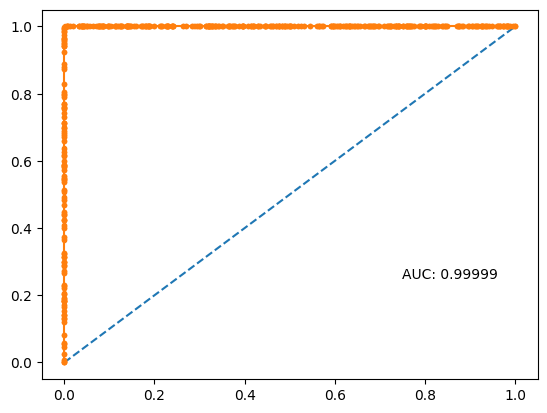

----------------------------------
DecisionTreeClassifier
----------------------------------
Confusion matrix:
[[12993    42]
 [   34  4238]]

Accuracy: 0.9956087132374184

Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13035
           1       0.99      0.99      0.99      4272

    accuracy                           1.00     17307
   macro avg       0.99      0.99      0.99     17307
weighted avg       1.00      1.00      1.00     17307


ROC / AUC:


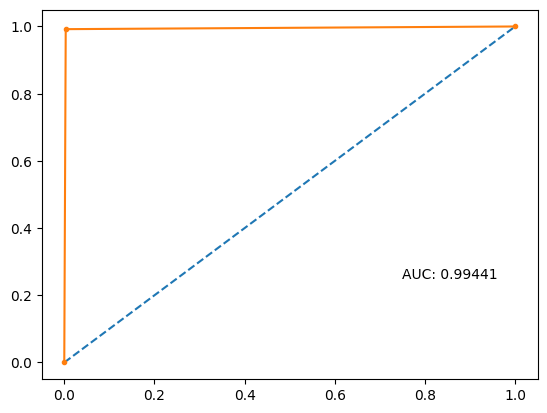

----------------------------------
KNeighborsClassifier
----------------------------------
Confusion matrix:
[[13015    20]
 [   24  4248]]

Accuracy: 0.9974576760848212

Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13035
           1       1.00      0.99      0.99      4272

    accuracy                           1.00     17307
   macro avg       1.00      1.00      1.00     17307
weighted avg       1.00      1.00      1.00     17307


ROC / AUC:


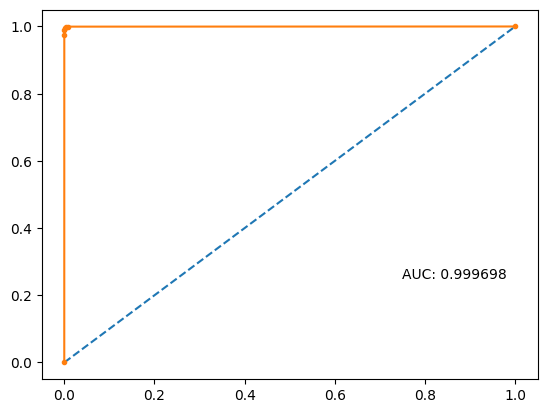

In [87]:
kbest = SelectKBest(score_func=f_classif, k=5)
kbest.fit(X, y)
print("Selected features:", list(X.columns[kbest.get_support()]), '\n\n')
X_ = kbest.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_, y, test_size=test_size, random_state=seed)

models = [LogisticRegression(), DecisionTreeClassifier(), KNeighborsClassifier()]
for model in models:
    model.fit(X_train, y_train)
    yhat = model.predict(X_test)
    print("----------------------------------")
    print(type(model).__name__)
    print("----------------------------------")
    print("Confusion matrix:")
    print(confusion_matrix(y_true=y_test, y_pred=yhat))

    print("\nAccuracy:", accuracy_score(y_true=y_test, y_pred=yhat))

    print("\nClassification report:")
    print(classification_report(y_true=y_test, y_pred=yhat))

    print("\nROC / AUC:")
    plotRocAuc(model, X_test, y_test)

In [84]:
# Logistic Regression is chosen because it has the least false classification in the confusion and highest AUC

Further evaluation with cross validation

In [73]:
model = LogisticRegression()

kfold = KFold(n_splits=5, shuffle=True, random_state=seed)

kbest = SelectKBest(score_func=f_classif, k=5)
kbest.fit(X, y)
print("Selected features:", list(X.columns[kbest.get_support()]), '\n')
X_ = kbest.transform(X)

# Train and evaluate multiple models using kfolds
results = cross_val_score(model, X_, y, cv=kfold, scoring='roc_auc')
print(results)
print("Mean:", results.mean())
print("Std:", results.std())

Selected features: ['Proximity_to_Mountains', 'Proximity_to_Beaches', 'hiking', 'skiing', 'sunbathing'] 

[0.99999037 0.99998705 1.         0.99997803 0.99999276]
Mean: 0.9999896434768246
Std: 7.2002173903723395e-06


In [85]:
# the model performs accurately and consistently with the average AUC = 0.99998964 with standard deviation < 0.000008

In [76]:
# the model can be further tested with other datasets to further verify its biasness and comprehensiveness